In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.formula.api import ols
from sklearn.svm import LinearSVC
from sklearn import metrics, linear_model, preprocessing
from sklearn.feature_selection import SelectKBest, f_regression, chi2, VarianceThreshold, SelectFromModel
from sklearn.metrics import roc_curve, auc, confusion_matrix

%matplotlib inline
sns.set(color_codes = True) 

### Load the dataset
We shall use the **'carprice.csv'** dataset for this exercise

In [83]:
df = pd.read_csv('../data/carprice.csv', na_values = '.')
print(df.shape)
df.head()

(5239, 17)


,car_id,price,Kilometers,hp,Brand,Sport,age,Users,gas,Metalilic,CC,Weight,QuartTax,Automatic,red,Owner_gender,door
0,3548,48750,NaN,110,6,YES,7,1,590.0,NO,1800,1170.0,100,YES,NO,M,4
1,903,16610,NaN,110,3,NO,8,1,391.0,YES,2200,1250.0,270,YES,NO,F,4
2,3903,27100,3040.0,110,2,YES,8,1,478.0,NO,1900,1186.0,120,YES,YES,M,4
3,5098,24240,4690.0,110,5,NO,8,1,NaN,NO,1800,1170.0,100,YES,NO,M,4
4,3364,13030,5820.0,110,5,NO,9,1,NaN,YES,2200,1250.0,80,NO,NO,F,4


### Check for missing values
For each **variable** in the data frame, check the number of missing values

In [84]:
d = df.isnull().sum()
print(d[d > 0])

Kilometers    358
gas           261
Weight        570
dtype: int64


In [85]:
print(f'Number of variables with missing values: {len(d[d > 0])}')

Number of variables with missing values: 3


In [86]:
print(df.dtypes)

car_id            int64
price             int64
Kilometers      float64
hp                int64
Brand             int64
Sport            object
age               int64
Users             int64
gas             float64
Metalilic        object
CC                int64
Weight          float64
QuartTax          int64
Automatic        object
red              object
Owner_gender     object
door              int64
dtype: object


**Extract the dataframe making sure the following numeric variables are `non-negative`**

In [87]:
df_new = df[(df['gas'] > 0) & (df['Kilometers'] > 0) & (df['age'] > 0) & (df['Weight'] > 0) & (df['QuartTax'] > 0)]
df_new = df_new[(df_new['door'] > 0) & (df_new['CC'] > 0) & (df_new['Users'] > 0) & (df_new['Brand'] > 0)]
df_new = df_new[(df_new['car_id'] > 0) & (df_new['price'] > 0) & (df_new['hp'] > 0)]
print(df_new.shape)
df_new.head(3)

(4133, 17)


,car_id,price,Kilometers,hp,Brand,Sport,age,Users,gas,Metalilic,CC,Weight,QuartTax,Automatic,red,Owner_gender,door
2,3903,27100,3040.0,110,2,YES,8,1,478.0,NO,1900,1186.0,120,YES,YES,M,4
5,2854,13940,106710.0,110,6,NO,9,1,357.0,YES,2200,1250.0,80,NO,NO,F,4
6,4187,22190,8610.0,110,4,NO,9,1,360.0,NO,1900,1186.0,160,YES,YES,F,4


#### Handling categorical variables
The following variables: **'Brand, hp, CC, Users, door'** are categorical variables rather than continuous. Categorical variables have levels while continuous variable don't.

In [88]:
varnames = ['Brand', 'hp', 'CC', 'Users', 'door']    
for vname in varnames:
    print(f'Levels for the variable "{vname}": {df_new[vname].value_counts().sort_index().index.values}')
    print(f'Number per level for the variable "{vname}": {df_new[vname].value_counts().sort_index().values}')
    print(f'Number of categories for the variable "{vname}": {len(df_new[vname].value_counts().sort_index().values)}\n\n')

Levels for the variable "Brand": [1 2 3 4 5 6]
Number per level for the variable "Brand": [ 542  560  645 1097  736  553]
Number of categories for the variable "Brand": 6


Levels for the variable "hp": [ 70  90 110 192]
Number per level for the variable "hp": [ 348 1175 1172 1438]
Number of categories for the variable "hp": 4


Levels for the variable "CC": [1600 1800 1900 2000 2200]
Number per level for the variable "CC": [ 473  914 1099  880  767]
Number of categories for the variable "CC": 5


Levels for the variable "Users": [1 2 3]
Number per level for the variable "Users": [2506 1360  267]
Number of categories for the variable "Users": 3


Levels for the variable "door": [2 4]
Number per level for the variable "door": [ 638 3495]
Number of categories for the variable "door": 2




### Generate dummy variables and impute missing values
Let's generate **missing dummy variables** for those **features with missing values**, and then **impute the values with missing values** with the **median** of those variables.

We will generate columns in the dataframe to indicate missing values (**1**) or no missing values (**0**). 

The 3 variables with missing values are **'Kilometers', 'gas', 'Weight'**.

In [89]:
import warnings
warnings.filterwarnings('ignore')

df_new['Kilometers_miss'] = df_new['Kilometers'].isnull() + 0   # df_new['Kilometers'].isnull() is True or False
df_new['gas_miss'] = df_new['gas'].isnull() + 0
df_new['Weight_miss'] = df_new['Weight'].isnull() + 0

df_new.head()

,car_id,price,Kilometers,hp,Brand,Sport,age,Users,gas,Metalilic,CC,Weight,QuartTax,Automatic,red,Owner_gender,door,Kilometers_miss,gas_miss,Weight_miss
2,3903,27100,3040.0,110,2,YES,8,1,478.0,NO,1900,1186.0,120,YES,YES,M,4,0,0,0
5,2854,13940,106710.0,110,6,NO,9,1,357.0,YES,2200,1250.0,80,NO,NO,F,4,0,0,0
6,4187,22190,8610.0,110,4,NO,9,1,360.0,NO,1900,1186.0,160,YES,YES,F,4,0,0,0
7,460,51300,11040.0,192,3,NO,9,1,380.0,NO,1900,1186.0,160,YES,YES,F,4,0,0,0
8,3587,35050,12720.0,192,5,YES,10,2,617.0,NO,1600,1165.0,100,YES,NO,M,2,0,0,0


#### Impute missing values with the `median` of its values

In [90]:
varnames = ['Kilometers','gas','Weight']

for vname in varnames:
      df_new[vname].fillna(df_new[vname].median(), inplace = True)     # replace missing value with median
df_new.sample(5)

,car_id,price,Kilometers,hp,Brand,Sport,age,Users,gas,Metalilic,CC,Weight,QuartTax,Automatic,red,Owner_gender,door,Kilometers_miss,gas_miss,Weight_miss
140,2024,18300,49210.0,90,5,NO,15,1,398.0,NO,2000,1195.0,160,YES,NO,F,4,0,0,0
4189,2812,9290,123200.0,110,2,NO,33,1,308.0,NO,2000,1195.0,190,NO,NO,M,4,0,0,0
4505,2711,18700,172200.0,192,3,NO,35,1,314.0,NO,1900,1186.0,160,YES,YES,M,4,0,0,0
993,1982,17300,94540.0,70,6,YES,22,1,429.0,NO,1800,1165.0,100,YES,NO,M,4,0,0,0
4698,3429,15580,210120.0,110,5,YES,35,2,538.0,YES,2200,1250.0,270,YES,YES,M,4,0,0,0


**Generate dummy variables for other categorical variables (use `pd.get_dummies`)**

In [91]:
Metalilic = 'Metalilic' + '_' + df_new.Metalilic.astype(str)     # 'Metalilic_YES' or 'Metalilic_NO'
df_Metalilic = pd.get_dummies(Metalilic)

df_Metalilic.head()

,Metalilic_NO,Metalilic_YES
2,1,0
5,0,1
6,1,0
7,1,0
8,1,0


**Let's do same to the rest...**

In [92]:
hp = 'hp' + '_' + df_new.hp.astype(str)
df_hp = pd.get_dummies(hp)

Brand = 'Brand' + '_' + df_new.Brand.astype(str)
df_Brand = pd.get_dummies(Brand)

Sport = 'Sport' + '_' + df_new.Sport.astype(str)
df_Sport = pd.get_dummies(Sport)

Users = 'Users' + '_' + df_new.Users.astype(str)
df_Users = pd.get_dummies(Users)

CC = 'CC' + '_' + df_new.CC.astype(str)
df_CC = pd.get_dummies(CC)

Automatic = 'Automatic' + '_' + df_new.Automatic.astype(str)
df_Automatic = pd.get_dummies(Automatic)

red = 'red' + '_' + df_new.red.astype(str)
df_red = pd.get_dummies(red)

Owner_gender = 'Owner_gender' + '_' + df_new.Owner_gender.astype(str)
df_Owner_gender = pd.get_dummies(Owner_gender)

door = 'door' + '_' + df_new.door.astype(str)
df_door = pd.get_dummies(door)

Append all the dummy variables generated above to the original data frame **'df_new'**

In [93]:
for df in [df_Metalilic, df_hp, df_Brand, df_Sport, df_Users, df_Automatic, df_red, df_Owner_gender, df_door]:
      df_new = pd.concat([df_new, df], axis = 1)

print(df_new.shape)
df_new.head()

(4133, 45)


,car_id,price,Kilometers,hp,Brand,Sport,age,Users,gas,Metalilic,...,Users_2,Users_3,Automatic_NO,Automatic_YES,red_NO,red_YES,Owner_gender_F,Owner_gender_M,door_2,door_4
2,3903,27100,3040.0,110,2,YES,8,1,478.0,NO,...,0,0,0,1,0,1,0,1,0,1
5,2854,13940,106710.0,110,6,NO,9,1,357.0,YES,...,0,0,1,0,1,0,1,0,0,1
6,4187,22190,8610.0,110,4,NO,9,1,360.0,NO,...,0,0,0,1,0,1,1,0,0,1
7,460,51300,11040.0,192,3,NO,9,1,380.0,NO,...,0,0,0,1,0,1,1,0,0,1
8,3587,35050,12720.0,192,5,YES,10,2,617.0,NO,...,1,0,0,1,1,0,0,1,1,0


Let's drop the variables **'Metalilic', 'hp', 'Brand', 'Sport', 'Users', 'CC', 'Automatic', 'red', 'Owner_gender', 
'door'** from the data frame 'df_new' since we have created dummies for them.

In [94]:
vnames = ['Metalilic', 'hp', 'Brand', 'Sport', 'Users', 'CC', 'Automatic', 'red', 'Owner_gender', 'door']
df_new.drop(vnames, axis = 1, inplace = True)                   # NOTE: no return value therefore inplace = True
df_new.head(2)

,car_id,price,Kilometers,age,gas,Weight,QuartTax,Kilometers_miss,gas_miss,Weight_miss,...,Users_2,Users_3,Automatic_NO,Automatic_YES,red_NO,red_YES,Owner_gender_F,Owner_gender_M,door_2,door_4
2,3903,27100,3040.0,8,478.0,1186.0,120,0,0,0,...,0,0,0,1,0,1,0,1,0,1
5,2854,13940,106710.0,9,357.0,1250.0,80,0,0,0,...,0,0,1,0,1,0,1,0,0,1


### QQ-plot of target variable
One of the most important assumption in training a linear regression model is that the target variable should be normally distributed. We will use the **QQ plot** graph to check if the target variable **'price'** is **normally distributed**. We will also check the **density** graph and **boxplot** for the target variable **'price'** to confirm the conclusion.

**The condition for a linear regression is that the target variable should be normally distributed**

In [96]:
y_train = df_new.price

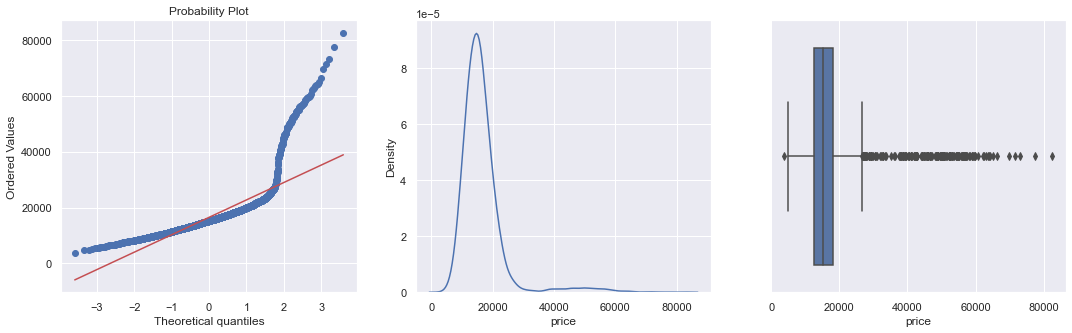

In [97]:
fig, axes = plt.subplots(1, 3, figsize = (18, 5), sharex = False)
stats.probplot(y_train, dist = 'norm', plot = axes[0])                # qq-plot
sns.kdeplot(y_train, ax = axes[1])
sns.boxplot(y_train, ax = axes[2])
plt.show()

The plots indicate that the target **price** is **not normally distributed**. The **density** plot shows that car prices after about **30000** are **outliers**. The **boxplot** shows we have too many **outliers**. Let's check for outliers in the dataset and remove them...

### Helper function to detect outliers
We will assume that any **data point (absolute value) greater than 3 times the standard deviation is an outlier**.

In [98]:
def detect_outliers(data):
    outliers = []
    threshold = 3                       # 3*std assuming std = 1 after transforming the data Standard Normal Distribution
    mean = np.mean(data)
    std = np.std(data)
    
    for x in data:
        z_score = (x - mean) / std       # transforms the dataset to have mean = 0 and SD = 1
        if np.abs(z_score) > threshold:
            outliers.append(x)
    return outliers

### Helper function to remove outliers from data
We shall calculate the **Lower fence(bound)** and **Upper fence(bound)** based on the **Inter Quartile Range (IQR)** and any data point outside these fences will be discarded as outliers.

In [99]:
def remove_outliers(data):
    dataset_new = []
    data = sorted(data)
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr
    for x in data:
        if (x >= lower_fence) & (x <= upper_fence):
            dataset_new.append(x)
    return dataset_new

**Detect outliers**

In [100]:
outliers = detect_outliers(y_train)
print(len(outliers))
print(outliers[:20])

121
[51300, 82540, 77370, 52440, 59730, 48240, 50860, 50740, 54480, 58410, 48720, 63890, 56890, 50320, 52630, 56090, 57420, 69710, 55730, 50390]


**Remove outliers from target variable**

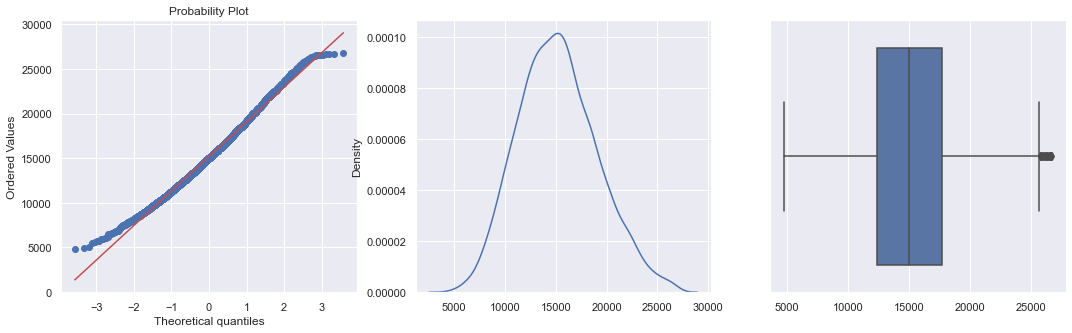

In [101]:
y_train_new = remove_outliers(y_train)

fig, axes = plt.subplots(1, 3, figsize = (18, 5), sharex = False)
stats.probplot(y_train_new, dist = 'norm', plot = axes[0])                # qq-plot
sns.kdeplot(y_train_new, ax = axes[1])
sns.boxplot(y_train_new, ax = axes[2])
plt.show()

In [103]:
lower_fence = min(y_train_new)
upper_fence = max(y_train_new)
print(f'lower fence = {lower_fence}\nupper fence = {upper_fence}')

lower fence = 4760
upper fence = 26750


### Truncate the DataFrame
We will truncate the DataFrame to align with the new target (with outliers removed).

In [104]:
print(f'Before truncation: {df_new.shape}')
df_fix = df_new[(df_new.price >= lower_fence) & (df_new.price <= upper_fence)]     # observations with outliers removed
print(f'After truncation: {df_fix.shape}')

Before truncation: (4133, 35)
After truncation: (3959, 35)


**Investigate the target one more time**

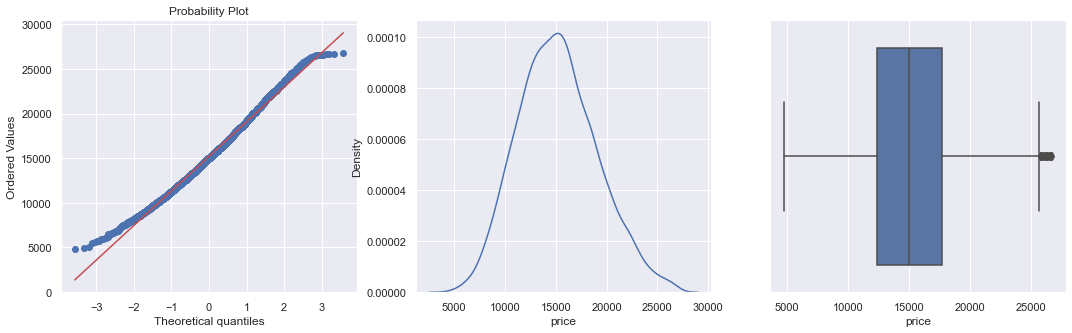

In [105]:
y_train = df_fix.price

fig, axes = plt.subplots(1, 3, figsize = (18, 5), sharex = False)
stats.probplot(y_train, dist = 'norm', plot = axes[0])               
sns.kdeplot(y_train, ax = axes[1])
sns.boxplot(y_train, ax = axes[2])
plt.show()

Our target is now fairly **normally distributed**!

### How good are these variables or features at predicting the price?
We will compute the **correlation between each independent** variable and the target variable **'price'**, and rank the absolute value of the **Pearson correlation coefficients in descending order**. This will give us some clues about the importance of eavh variable in predicting the target.

In [106]:
varnames = list(df_fix)
print(varnames)

['car_id', 'price', 'Kilometers', 'age', 'gas', 'Weight', 'QuartTax', 'Kilometers_miss', 'gas_miss', 'Weight_miss', 'Metalilic_NO', 'Metalilic_YES', 'hp_110', 'hp_192', 'hp_70', 'hp_90', 'Brand_1', 'Brand_2', 'Brand_3', 'Brand_4', 'Brand_5', 'Brand_6', 'Sport_NO', 'Sport_YES', 'Users_1', 'Users_2', 'Users_3', 'Automatic_NO', 'Automatic_YES', 'red_NO', 'red_YES', 'Owner_gender_F', 'Owner_gender_M', 'door_2', 'door_4']


In [107]:
varnames.remove('price')        # target
varnames.remove('car_id')       # not a predictor
print(varnames)

['Kilometers', 'age', 'gas', 'Weight', 'QuartTax', 'Kilometers_miss', 'gas_miss', 'Weight_miss', 'Metalilic_NO', 'Metalilic_YES', 'hp_110', 'hp_192', 'hp_70', 'hp_90', 'Brand_1', 'Brand_2', 'Brand_3', 'Brand_4', 'Brand_5', 'Brand_6', 'Sport_NO', 'Sport_YES', 'Users_1', 'Users_2', 'Users_3', 'Automatic_NO', 'Automatic_YES', 'red_NO', 'red_YES', 'Owner_gender_F', 'Owner_gender_M', 'door_2', 'door_4']


### Calculate and rank the correlation coefficients
We will use the **pearson correlation** to calcualte the correlations

In [108]:
Y = df_fix.price                               # target
corrs = []
for vaname in varnames:
    X = df_fix[vaname]                         # each variable
    corr, p_value = stats.pearsonr(X, Y)       # correlation between each variable and the target
    corr = np.round(corr, 3)
    corrs.append(corr)
    
corr_df = pd.DataFrame({'varname': varnames, 'correlation': corrs})
corr_df.head()

,varname,correlation
0,Kilometers,-0.208
1,age,-0.240
2,gas,0.006
3,Weight,0.004
4,QuartTax,-0.002


#### Rank the absolute correlations

In [109]:
corr_df['ab_corr'] = np.abs(corr_df['correlation'])
corr_df.sort_values(by = ['ab_corr'], ascending = False, inplace = True)
seq = range(1, len(corr_df) + 1)
corr_df['order'] = seq
corr_df.head(20)

,varname,correlation,ab_corr,order
26,Automatic_YES,0.742,0.742,1
25,Automatic_NO,-0.742,0.742,2
11,hp_192,0.272,0.272,3
1,age,-0.240,0.240,4
0,Kilometers,-0.208,0.208,5
14,Brand_1,-0.166,0.166,6
19,Brand_6,0.149,0.149,7
13,hp_90,-0.145,0.145,8
18,Brand_5,0.104,0.104,9
12,hp_70,-0.102,0.102,10


In [110]:
print(corr_df.shape)

(33, 4)


### Feature selection I
By intuition let's choose the **top 20 variables based on the correlation coefficients** above, transform the data with 
the **range standardization** and put them into the **linear regression model with LASO** to select final 
candidates.

In [111]:
var_names = list(corr_df.varname)[:20]         
var_names

['Automatic_YES',
 'Automatic_NO',
 'hp_192',
 'age',
 'Kilometers',
 'Brand_1',
 'Brand_6',
 'hp_90',
 'Brand_5',
 'hp_70',
 'Brand_2',
 'hp_110',
 'Users_3',
 'Users_1',
 'Brand_3',
 'Brand_4',
 'red_NO',
 'red_YES',
 'Users_2',
 'Owner_gender_F']

In [112]:
X_train = df_fix[var_names]

#### Standardize the selected data

In [113]:
min_max_scaler = preprocessing.MinMaxScaler()

X_train_minmax = 100 * min_max_scaler.fit_transform(X_train)        # x100 still maintain the standardization
X_train_minmax

array([[  0., 100.,   0., ...,   0.,   0., 100.],
       [100.,   0.,   0., ..., 100.,   0., 100.],
       [100.,   0.,   0., ..., 100., 100.,   0.],
       ...,
       [100.,   0.,   0., ...,   0.,   0., 100.],
       [100.,   0.,   0., ...,   0.,   0.,   0.],
       [  0., 100., 100., ...,   0.,   0., 100.]])

### Feature selection ll
We will apply **LASSO** to select final features for the model. **LASSO** is actually a fitting function (linear regression) but with *penalty*.

In [114]:
Y = df_fix.price

In [115]:
model = linear_model.Lasso(alpha = 0.1, max_iter = 10000)      
model.fit(X_train_minmax, Y)

print(f'Intercept: {model.intercept_}\n')
print(f'The first 10 coefficients:\n {model.coef_[:10]}')

Intercept: 13856.232616171037

The first 10 coefficients:
 [ 63.95687495  -0.          25.64871009 -78.50440479  -5.54279853
 -20.88217659  17.99787225  -3.62521632  10.58179295  -8.56437428]


Let's check the **percentiles of the coefficients** selected from LASSO and use a threshold based on this to choose a set of features.

In [116]:
q = list(np.arange(5, 100, 5))
for p in q:
    print(f'The {p}th percentile is: {np.percentile(abs_coef, p)}')

The 5th percentile is: 0.0
The 10th percentile is: 0.0
The 15th percentile is: 0.09238365513377937
The 20th percentile is: 0.1354532980168517
The 25th percentile is: 0.2622089206155895
The 30th percentile is: 1.0597675390906
The 35th percentile is: 1.4711962489760286
The 40th percentile is: 2.323647103896187
The 45th percentile is: 3.2812287609470783
The 50th percentile is: 4.562172156556429
The 55th percentile is: 5.51877973324965
The 60th percentile is: 6.75142883137887
The 65th percentile is: 9.270470813281053
The 70th percentile is: 11.434783808317999
The 75th percentile is: 14.568289926076483
The 80th percentile is: 18.57473312210295
The 85th percentile is: 21.597156616346922
The 90th percentile is: 29.4795265771032
The 95th percentile is: 64.68425143793559


As we can see about **30%** of the coefficients are less than **1**. We shall therefore select those variables whose cofficients are greater than **1**.

In [117]:
L = len(list(model.coef_))                                          # the coefficients are in same order as var_names
chosen_vars = [var_names[i] for i in range(L) if abs_coef[i] > 0.9]              
print(f'These {len(chosen_vars)} variables are selected based on LASSO:\n\n{chosen_vars}')

These 14 variables are selected based on LASSO:

['Automatic_YES', 'hp_192', 'age', 'Kilometers', 'Brand_1', 'Brand_6', 'hp_90', 'Brand_5', 'hp_70', 'Brand_2', 'hp_110', 'Users_3', 'Brand_3', 'Brand_4']


**A dataframe that contains the only variables selected from the LASSO above...**

In [118]:
chosen_vars.extend(['price'])        # include the target
selected_df = df_fix[chosen_vars]

print(selected_df.shape)
selected_df.head()

(3959, 15)


,Automatic_YES,hp_192,age,Kilometers,Brand_1,Brand_6,hp_90,Brand_5,hp_70,Brand_2,hp_110,Users_3,Brand_3,Brand_4,price
5,0,0,9,106710.0,0,1,0,0,0,0,1,0,0,0,13940
6,1,0,9,8610.0,0,0,0,0,0,0,1,0,0,1,22190
9,1,0,9,11490.0,0,0,0,0,0,1,1,0,0,0,17290
12,1,0,9,15330.0,1,0,0,0,0,0,1,0,0,0,19840
13,0,1,11,16380.0,0,0,0,0,0,1,0,0,0,0,13230


### Feature selection III(i)
We shall now apply the Ordinary Least Square (**OLS**) package (or ANOVA) to **fit** the model and observe the **p values** and **coefficients** for the different variables. **OLS** is equivalent to Scikit Learn's linear regression model but it also provide **pvalues** to help in the further selection of important variables for the final model.

The **p-value** tells us **if there is a correlation** between **independent variables** and **target**.

The **null hypothesis H0** is that there is **no correlation** between **independent variables** and **target**. That is the **coefficients are equal to zero (no relationship)**. Also that **intercept = 0**. 

* A **low p-value (< 0.05)** means that the coefficient is likely **not to equal zero**. That is the **variable is strongly correlated with the target. Reject the null hypothesis**!

* A **high P-value (> 0.05)** means that we **cannot** conclude that the **independent variable is correlated** with the dependent variable (**target**). That is we **fail to reject the null hypothesis**.
* A **high p-value** is also called an **insignificant P-value**.

**R-Squared** and **Adjusted R-Squared** describes how well **the linear regression model fits the data points**. A **high R-Squared** value means that many data points are close to the linear regression function line.

In [119]:
ols_model = ols('price ~ Automatic_YES + hp_192 + age + Kilometers + Brand_1 + Brand_6 + hp_90 + \
hp_70 + Brand_5 + Brand_2 + hp_110 + Users_3 + Brand_4 + Brand_3', selected_df).fit()

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     1559.
Date:                Fri, 13 May 2022   Prob (F-statistic):               0.00
Time:                        07:48:14   Log-Likelihood:                -34878.
No. Observations:                3959   AIC:                         6.978e+04
Df Residuals:                    3946   BIC:                         6.986e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.114e+04     88.494    125.897

The **pvalues** for the variables **Kilometers, Brand_1, Users_3** are **larger** than the threshold of **0.05**. This suggests that these variables have **no significant** impact on the target **price** and therefore cannot be used to **predict price**. The variables **Kilometers, Brand_1, Users_3** should therefore **not be included** in the final model. We **fail to reject the null hypothesis in these cases**.

### Feature selection III(ii)
Based on the **p values** above, we will select the final key drivers, use the OLS again to fit the linear regression model, observe **p values** and coefficients and finally check the **F statistics** and **R square** values.

In [120]:
ols_model = ols('price ~ Automatic_YES + hp_192 + age + Brand_6 + hp_90 + \
hp_70 + Brand_5 + Brand_2 + hp_110 + Brand_4 + Brand_3', selected_df).fit()

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     1870.
Date:                Fri, 13 May 2022   Prob (F-statistic):               0.00
Time:                        07:57:57   Log-Likelihood:                -34880.
No. Observations:                3959   AIC:                         6.978e+04
Df Residuals:                    3948   BIC:                         6.985e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.112e+04    109.144    101.866

#### The Coefficients

In [125]:
r_square = ols_model.rsquared
print(f'R^2 = {r_square}')
pvalue_model = ols_model.f_pvalue

intercept = ols_model.params['Intercept']
coef_age = ols_model.params['age']
coef_Automatic_YES = ols_model.params['Automatic_YES']
coef_Brand_2 = ols_model.params['Brand_2']
coef_Brand_3 = ols_model.params['Brand_3']
coef_Brand_4 = ols_model.params['Brand_4']
coef_Brand_5 = ols_model.params['Brand_5']
coef_Brand_6 = ols_model.params['Brand_6']
coef_hp_70 = ols_model.params['hp_70']
coef_hp_90 = ols_model.params['hp_90']
coef_hp_110 = ols_model.params['hp_110']
coef_hp_192 = ols_model.params['hp_192']

coef_names = ['age', 'Automatic_YES', 'Brand_2', 'Brand_3', 'Brand_4', 'Brand_5', 'Brand_6', 
              'hp_70', 'hp_90', 'hp_110', 'hp_192']
coefficients = [coef_age, coef_Automatic_YES, coef_Brand_2, coef_Brand_3, coef_Brand_4, coef_Brand_5, coef_Brand_6,
               coef_hp_70, coef_hp_90, coef_hp_110, coef_hp_192]

alpha = 0.05
if pvalue_model <= alpha:
    print('Good model')
else:
    print('Bad model')

print(f'\nIntercept = {intercept}\n')
print(f'Coefficients(OLS):')
for name, coef in zip(coef_names, coefficients):
    print(f'{name} = {coef}')

R^2 = 0.8256512467243898
Good model

Intercept = 11118.04365201206

Coefficients(OLS):
age = -193.02222210130628
Automatic_YES = 6396.731978660648
Brand_2 = 749.6559840664681
Brand_3 = 1542.1962607656596
Brand_4 = 2377.4724261549304
Brand_5 = 3150.4847334453875
Brand_6 = 3890.7732171533476
hp_70 = 1549.9419345994502
hp_90 = 2043.0889892389964
hp_110 = 2553.735369247657
hp_192 = 4971.27735892591


The model **pvalue** and **R^2** indicate that the model is good!
### Model with scikit learn
We shall now use Scikit Learn's **`LinearRegression`** to fit the model and compare the output with those obtained from OLS.

In [126]:
#final = ['Automatic_YES', 'hp_192', 'age', 'Brand_6', 'hp_90', 'hp_70', 'Brand_5', 'Brand_2', 'hp_110', 'Brand_4', 'Brand_3']
final = ['age', 'Automatic_YES', 'Brand_2', 'Brand_3', 'Brand_4', 'Brand_5', 'Brand_6', 'hp_70', 'hp_90', 'hp_110', 'hp_192']

X = selected_df[final]
Y = selected_df.price

min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X)

lin_reg= linear_model.LinearRegression()
lin_reg.fit(X_train_minmax, Y)
#print(f'Intercept: {lin_reg.intercept_}\n\nCoefficients:\n{lin_reg.coef_}')

print(f'Intercept = {lin_reg.intercept_}\n')
print(f'Coefficients(SKLearn):')
for name, coef in zip(final, lin_reg.coef_):
    print(f'{name} = {coef}')

Intercept = -3.1339685574356724e+16

Coefficients(SKLearn):
age = -8309.98282326408
Automatic_YES = 6398.869277429682
Brand_2 = 759.5548110654736
Brand_3 = 1538.0097818397346
Brand_4 = 2376.850870246096
Brand_5 = 3146.2898745475113
Brand_6 = 3893.064383284383
hp_70 = 3.1339685574367668e+16
hp_90 = 3.1339685574368144e+16
hp_110 = 3.133968557436867e+16
hp_192 = 3.1339685574371068e+16


#### Get the predictions and calculate statistics.
Conduct **model prediction** to predict car prices in the training data set. Find prediction errors of all 
observations in the training data. Calculate MSE, SST, MSE and F statistics values, and compare these 
results with the previous outputs from the OLS package

In [127]:
y_pred = lin_reg.predict(X_train_minmax)
y_avg = np.mean(Y)
y_pred_avg = np.mean(y_pred)
r_sq = np.sum((y_pred - y_pred_avg) ** 2) / np.sum((Y - y_avg) ** 2)
print('R square:', np.round(r_sq, 3))

# get Root Mean Squared Logarithmic Error
num_rows = len(X)   # X.shape[0]
RMSLE  = np.sqrt(np.sum((y_pred - Y)**2) / num_rows )
print('RMSLE is ' + str(RMSLE))

R square: 0.825
RMSLE is 1622.1451655495218


### Visualize the results
#### Scatter plot of the price prediction and prediction error
A scatter plot of prediction (**y_pred**) and prediction error or residue **(Y - y_pred)** for a good model should show no visible relationship, it should be *noisy*!

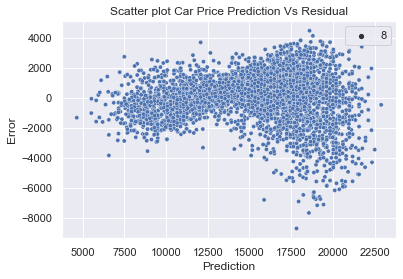

In [128]:
residue = y_pred - Y
sns.scatterplot(x = y_pred, y = residue, size = 8)

plt.title('Scatter plot Car Price Prediction Vs Residual')
plt.xlabel('Prediction')
plt.ylabel('Error')
plt.show() 

**Scatter plot of actual price (Y) and prediction (y_pred) showing the regression line**

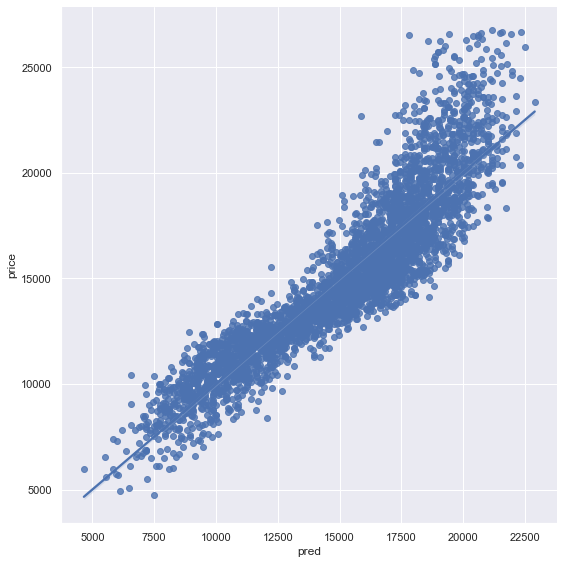

In [129]:
selected_df['pred'] = y_pred
sns.lmplot(x = 'pred', y = 'price', data = selected_df, fit_reg = True, height = 8) 
plt.show()

From the plot above it can be seen that the model finds it **harder to predict higher car prices**.
#### Scatter plot with raw data points and two regression lines based on Automatic = 'YES' and Automatic= 'No'

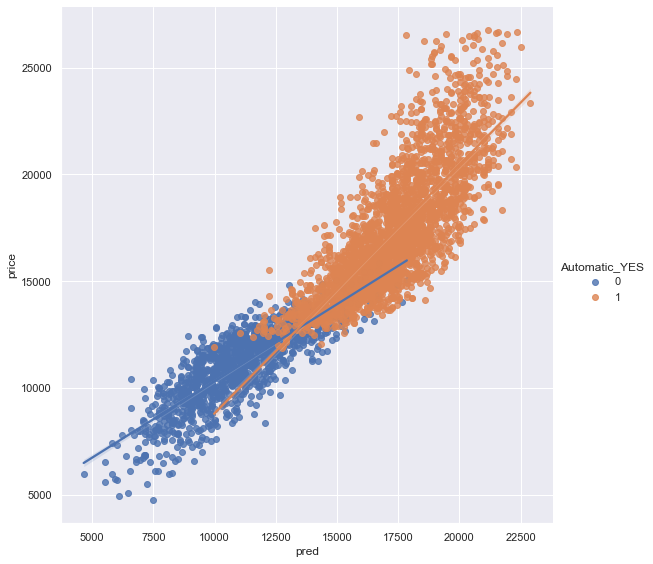

In [130]:
sns.lmplot(x = 'pred', y = 'price', data = selected_df, fit_reg = True, height = 8, hue = 'Automatic_YES')
plt.show()

The plot of **price prediction Vs prediction error** shows **no relationship** as expected. This is another proof that the model is working. In statistics the error and the prediction are **orthogonal**. This means the error cannot be predicted. Had it been there was a pattern this would have suggested that the error can still be predicted. 